In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.style as style
from torchsummary import summary


In [2]:
!pip install cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.6 MB/s eta 0:00:00


In [80]:
import torchvision
import numpy as np

# Define transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5 ,0.5), (0.5,0.5,0.5))])

import torch.utils.data as data

# Define the transform to apply to the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR-10 training and test datasets separately
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Combine the training and test datasets into a single dataset
dataset = torch.utils.data.ConcatDataset([trainset, testset])

# Create a dataloader for the combined dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                          shuffle=True, num_workers=2)

# Print the shapes of the loaded data
print('Combined Images:', len(dataset))
print('Combined Labels:', len(trainset.targets) + len(testset.targets))
dataset.targets = trainset.targets + testset.targets

Files already downloaded and verified
Files already downloaded and verified
Combined Images: 60000
Combined Labels: 60000


In [81]:
# Split indices into train, val, and test sets
np.random.seed(42)
train_indices = np.arange(len(dataset))
np.random.shuffle(train_indices)
test_indices = np.arange(len(dataset))

train_size = 12000
val_size = 48000


train_indices = []
val_indices = []

for i in range(10):
    class_indices = np.where(np.array(dataset.targets) == i)[0]
    np.random.shuffle(class_indices)
    train_indices.extend(class_indices[:1200])
    val_indices.extend(class_indices[1200:6000])

np.random.shuffle(train_indices)
np.random.shuffle(val_indices)
np.random.shuffle(test_indices)

In [82]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, train_indices), batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, val_indices), batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, test_indices), batch_size=128, shuffle=False, num_workers=2)

train_loader.pin_memory = True
val_loader.pin_memory = True
test_loader.pin_memory = True


Trainset Label distribution:
3: 1200 (10.00%)
4: 1200 (10.00%)
0: 1200 (10.00%)
9: 1200 (10.00%)
7: 1200 (10.00%)
8: 1200 (10.00%)
6: 1200 (10.00%)
2: 1200 (10.00%)
5: 1200 (10.00%)
1: 1200 (10.00%)


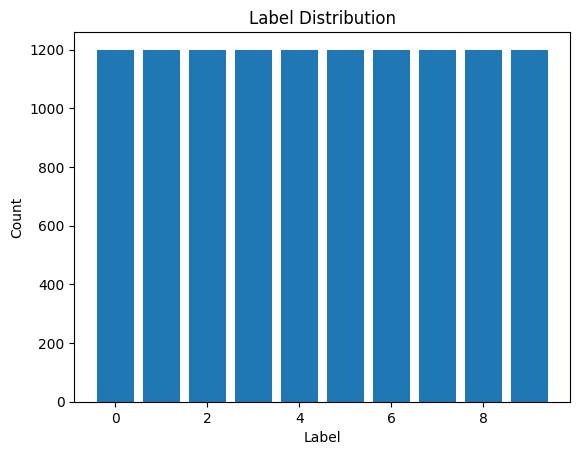

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

labels = []
for batch in train_loader:
    _, label = batch
    labels.extend(label.tolist())

label_counts = Counter(labels)
total_count = sum(label_counts.values())

print("Trainset Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} ({count/total_count:.2%})")

plt.bar(label_counts.keys(), label_counts.values())
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Label distribution:
6: 4800 (10.00%)
1: 4800 (10.00%)
4: 4800 (10.00%)
8: 4800 (10.00%)
0: 4800 (10.00%)
7: 4800 (10.00%)
5: 4800 (10.00%)
9: 4800 (10.00%)
2: 4800 (10.00%)
3: 4800 (10.00%)


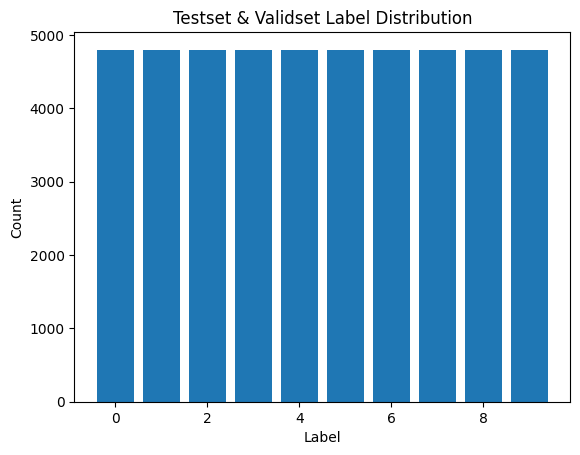

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

labels = []
for batch in val_loader:
    _, label = batch
    labels.extend(label.tolist())

label_counts = Counter(labels)
total_count = sum(label_counts.values())

print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} ({count/total_count:.2%})")

plt.bar(label_counts.keys(), label_counts.values())
plt.title('Testset & Validset Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [98]:
import torch
import torchvision.models as models

# Load the ResNet18 model
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
input_size = (3, 32, 32)

# Print the model summary
summary(model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Training data on clean train dataset and testing on clean test dataset

In [99]:
import matplotlib.pyplot as plt

# Initialize lists to store data for plotting
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 15
for epoch in range(num_epochs):
    # Training loop
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Epoch {epoch+1},: Training Loss {epoch_loss:.3f}")

    # Validation loop
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        # Save validation data
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100 * correct_val / total_val)

    # Print validation accuracy for each epoch
    print(f"Epoch {epoch+1} - Validation Accuracy: {(100*correct_val/total_val):.2f}%")
    print(f"Epoch {epoch+1} - Validation Loss: {(val_loss/len(val_loader))}")


Epoch 1,: Training Loss 2.277
Epoch 1 - Validation Accuracy: 31.86%
Epoch 1 - Validation Loss: 1.9739702809651694
Epoch 2,: Training Loss 1.807
Epoch 2 - Validation Accuracy: 39.59%
Epoch 2 - Validation Loss: 1.7007662515640258
Epoch 3,: Training Loss 1.554
Epoch 3 - Validation Accuracy: 44.45%
Epoch 3 - Validation Loss: 1.5346712042490642
Epoch 4,: Training Loss 1.428
Epoch 4 - Validation Accuracy: 48.19%
Epoch 4 - Validation Loss: 1.4190228417714437
Epoch 5,: Training Loss 1.321
Epoch 5 - Validation Accuracy: 52.04%
Epoch 5 - Validation Loss: 1.337681087811788
Epoch 6,: Training Loss 1.196
Epoch 6 - Validation Accuracy: 54.41%
Epoch 6 - Validation Loss: 1.2691819316546122
Epoch 7,: Training Loss 1.098
Epoch 7 - Validation Accuracy: 57.08%
Epoch 7 - Validation Loss: 1.1959835206667582
Epoch 8,: Training Loss 0.992
Epoch 8 - Validation Accuracy: 58.86%
Epoch 8 - Validation Loss: 1.1607842683792113
Epoch 9,: Training Loss 0.897
Epoch 9 - Validation Accuracy: 61.33%
Epoch 9 - Validation 

In [100]:
torch.save(model.state_dict(), 'resnet18.pth')


<ipython-input-38-013bc8ce6a29>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


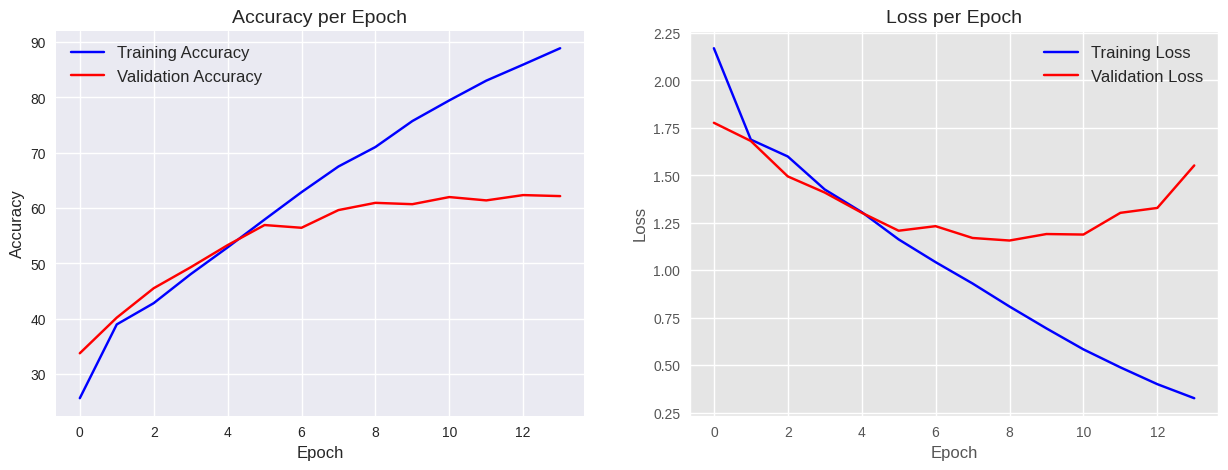

In [ ]:
style.use('seaborn')

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Training Accuracy", color = "blue")
plt.plot(val_accs, label="Validation Accuracy", color = "red")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy per Epoch", fontsize=14)
plt.legend(fontsize=12)
plt.style.use("ggplot")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Training Loss", color = "blue")
plt.plot(val_losses, label="Validation Loss", color = "red")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss per Epoch", fontsize=14)
plt.style.use("ggplot")
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

In [28]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method


In [ ]:
correct_test = 0
total_test = 0
model.eval()
for data in val_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    #inputs = fast_gradient_method(model_fn=model, x=inputs, eps=0.1, norm=np.inf)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

# Print test accuracy
print(f"Test Accuracy: {(100*correct_test/total_test):.2f}%")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6cc0be73a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6cc0be73a0>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    if w.is_alive():    
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
AssertionError    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py"

Test Accuracy: 62.66%


In [135]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=894cd95a9117040b23c7f4e63e6d46e9e20daa50e7eaad07e395bab5ba25495e
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=365656753feaa542fedc11214b7cf97c0735f506c565a3bf24136d737b52323a
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


umap on train data fit and then transform

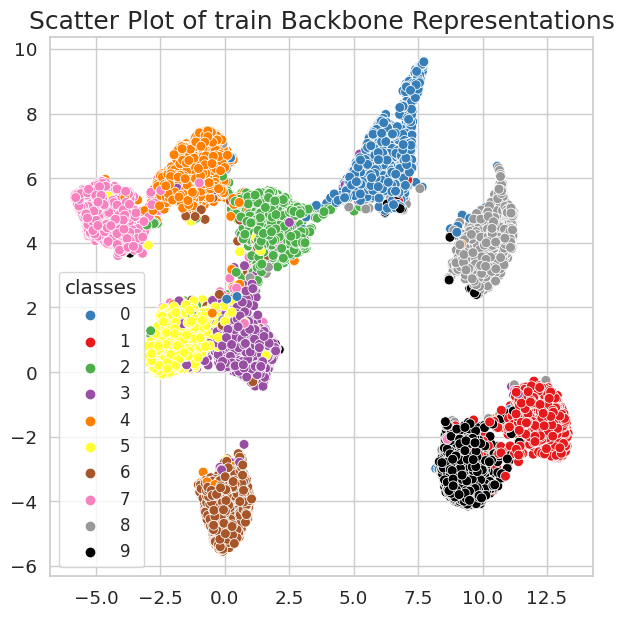

In [ ]:
backbone = nn.Sequential(*list(model.children())[:-1])
import umap.umap_ as umap
import numpy as np

embeddings = []
labels = []
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        feats = backbone(inputs)
        feats = feats.view(feats.size(0), -1)
        embeddings.append(feats.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Reduce the dimensionality of the embeddings to 2 using UMAP
reducer = umap.UMAP()
embeddings_2d = reducer.fit(embeddings)
train_emb = reducer.transform(embeddings)
import matplotlib.pyplot as plt


import seaborn as sns

sns.set(style='whitegrid', font_scale=1.2)

# Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000']
plt.figure(figsize=(7, 7))
sns.scatterplot(x=train_emb[:, 0], y=train_emb[:, 1], hue=labels, s=50, palette=colors)

# Add axis labels and title
plt.title('Scatter Plot of train Backbone Representations', fontsize=18)

# Add legend
plt.legend(title='classes', loc='best', fontsize=12)

# Add grid lines
plt.grid(True)

        
# Show the plot
plt.show()

umap on tets data transform

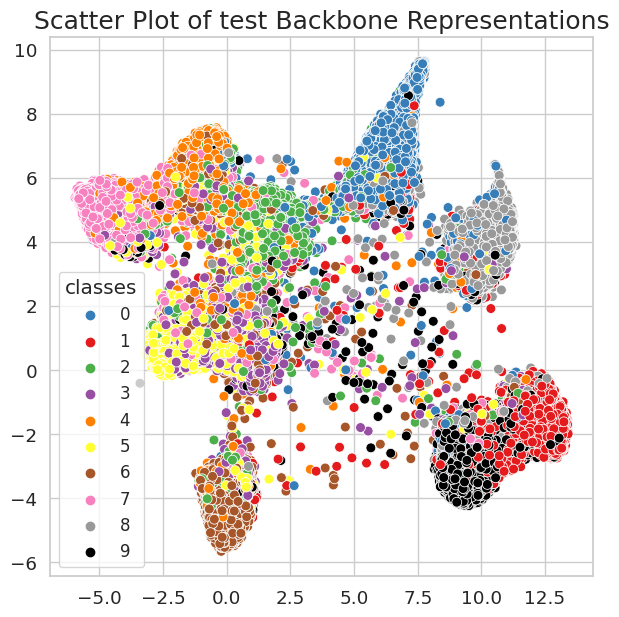

In [ ]:
import umap.umap_ as umap
import numpy as np

embeddings = []
labels = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        feats = backbone(inputs)
        feats = feats.view(feats.size(0), -1)
        embeddings.append(feats.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Reduce the dimensionality of the embeddings to 2 using UMAP
test_emb = reducer.transform(embeddings)
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.2)

# Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000']
plt.figure(figsize=(7, 7))
sns.scatterplot(x=test_emb[:, 0], y=test_emb[:, 1], hue=labels, s=50, palette=colors)

# Add axis labels and title
plt.title('Scatter Plot of test Backbone Representations', fontsize=18)

# Add legend
plt.legend(title='classes', loc='best', fontsize=12)

# Add grid lines
plt.grid(True)

        
# Show the plot
plt.show()

making corrupted dataset

In [85]:

import matplotlib.pyplot as plt
import random
def pixelchange(x):
    for _ in range(20):
        x[0][int(random.random()*32)][int(random.random()*32)] = 1
        x[1][int(random.random()*32)][int(random.random()*32)] = 1
        x[2][int(random.random()*32)][int(random.random()*32)] = 1
    return x


# Define the new transformations
test_transform_perturbate = transforms.Compose([
    transforms.ColorJitter(brightness=0.6, contrast=0.5, saturation=0.2, hue=0),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: pixelchange(x)),
    transforms.Normalize((0.5, 0.5 ,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=test_transform_perturbate)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform_perturbate)

# Combine the training and test datasets into a single dataset
dataset_corrupted = torch.utils.data.ConcatDataset([trainset, testset])


# Apply the new transformations to the test dataset
val_loader_perturbate = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_corrupted, val_indices), batch_size=128, shuffle=False, num_workers=2)

      

Files already downloaded and verified
Files already downloaded and verified


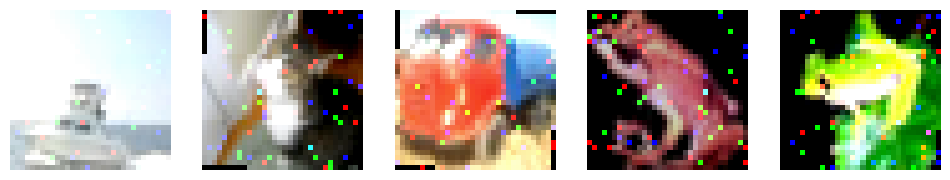

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 2.5))

for i in range(5):
    image, label = dataset_corrupted[i+100]
    image = np.transpose(image.numpy(), (1, 2, 0))
    axes[i].imshow(image)
    axes[i].axis("off")

plt.show()  

test on corrupted dataset

In [87]:
correct_test = 0
total_test = 0
model.eval()
for data in val_loader_perturbate:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    #inputs = fast_gradient_method(model_fn=model, x=inputs, eps=0.1, norm=np.inf)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

# Print test accuracy
print(f"Test Accuracy: {(100*correct_test/total_test):.2f}%")

Test Accuracy: 45.21%


test on corrupted dataset + fgm

In [68]:
correct_test = 0
total_test = 0
model.eval()
for data in val_loader_perturbate:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = fast_gradient_method(model_fn=model, x=inputs, eps=0.1, norm=np.inf)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

# Print test accuracy
print(f"Test Accuracy: {(100*correct_test/total_test):.2f}%")

Test Accuracy: 17.57%


umap for corrupted test set

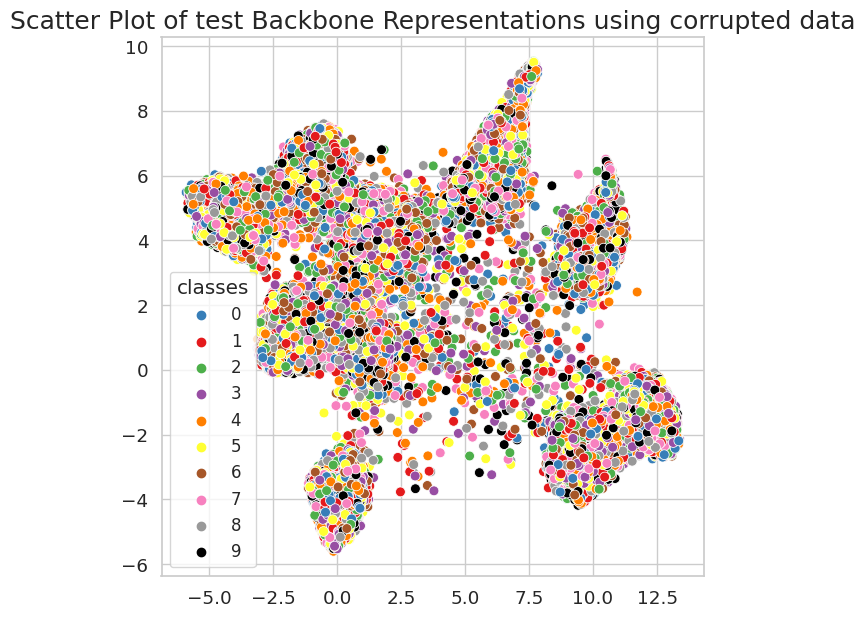

In [ ]:
import umap.umap_ as umap
import numpy as np

embeddings = []
labels = []
with torch.no_grad():
    for inputs, targets in val_loader_perturbate:
        inputs = inputs.to(device)
        targets = targets.to(device)
        feats = backbone(inputs)
        feats = feats.view(feats.size(0), -1)
        embeddings.append(feats.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Reduce the dimensionality of the embeddings to 2 using UMAP
test_emb = reducer.transform(embeddings)
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.2)

# Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000']
plt.figure(figsize=(7, 7))
sns.scatterplot(x=test_emb[:, 0], y=test_emb[:, 1], hue=labels, s=50, palette=colors)

# Add axis labels and title
plt.title('Scatter Plot of test Backbone Representations using corrupted data', fontsize=18)

# Add legend
plt.legend(title='classes', loc='best', fontsize=12)

# Add grid lines
plt.grid(True)

        
# Show the plot
plt.show()

In [128]:
batch_size = 128

train_loader_corrupted = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_corrupted, train_indices), batch_size=128, shuffle=True, num_workers=2)
val_loader_corrupted = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_corrupted, val_indices), batch_size=128, shuffle=False, num_workers=2)
test_loader_corrupted = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_corrupted, val_indices), batch_size=128, shuffle=False, num_workers=2)

train_loader_corrupted.pin_memory = True
val_loader_corrupted.pin_memory = True
test_loader_corrupted.pin_memory = True


In [ ]:
#model2 = torchvision.models.resnet18(pretrained=False)
#model2.fc = torch.nn.Linear(in_features=model2.fc.in_features, out_features=10)

#state_dict = torch.load('/content/resnet18.pth')
#model2.load_state_dict(state_dict)
#model2.to(device)

In [131]:
import torch
import torchvision.models as models

# Load the ResNet18 model
model2 = models.resnet18(pretrained=False)
model2.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model2.parameters(), lr=0.01, weight_decay=0.01)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [132]:
import matplotlib.pyplot as plt

# Initialize lists to store data for plotting
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 20
for epoch in range(num_epochs):
    # Training loop
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader_corrupted, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #inputs = fast_gradient_method(model_fn=model2, x=inputs, eps=0.1, norm=np.inf)
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_loader_corrupted)
    epoch_acc = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Epoch {epoch+1},: Training Loss {epoch_loss:.3f}")

    # Validation loop
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader_corrupted:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        # Save validation data
        val_losses.append(val_loss / len(val_loader_corrupted))
        val_accs.append(100 * correct_val / total_val)

    # Print validation accuracy for each epoch
    print(f"Epoch {epoch+1} - Validation Accuracy: {(100*correct_val/total_val):.2f}%")
    print(f"Epoch {epoch+1} - Validation Loss: {(val_loss/len(val_loader))}")


Epoch 1,: Training Loss 2.318
Epoch 1 - Validation Accuracy: 29.17%
Epoch 1 - Validation Loss: 1.920850775718689
Epoch 2,: Training Loss 1.878
Epoch 2 - Validation Accuracy: 36.92%
Epoch 2 - Validation Loss: 1.7241094077428183
Epoch 3,: Training Loss 1.736
Epoch 3 - Validation Accuracy: 39.50%
Epoch 3 - Validation Loss: 1.6795868469874065
Epoch 4,: Training Loss 1.625
Epoch 4 - Validation Accuracy: 39.32%
Epoch 4 - Validation Loss: 1.6451758019129434
Epoch 5,: Training Loss 1.565
Epoch 5 - Validation Accuracy: 43.92%
Epoch 5 - Validation Loss: 1.5388174107869466
Epoch 6,: Training Loss 1.453
Epoch 6 - Validation Accuracy: 45.83%
Epoch 6 - Validation Loss: 1.4965484612782796
Epoch 7,: Training Loss 1.404
Epoch 7 - Validation Accuracy: 47.27%
Epoch 7 - Validation Loss: 1.4682843713760376
Epoch 8,: Training Loss 1.355
Epoch 8 - Validation Accuracy: 49.70%
Epoch 8 - Validation Loss: 1.4002640701929727
Epoch 9,: Training Loss 1.272
Epoch 9 - Validation Accuracy: 51.70%
Epoch 9 - Validation 

<ipython-input-133-013bc8ce6a29>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


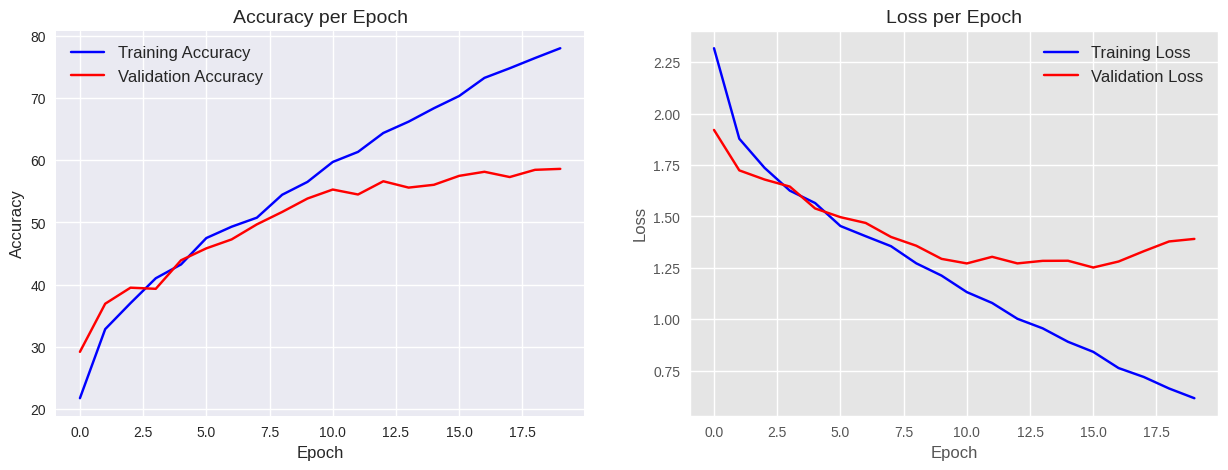

In [133]:
style.use('seaborn')

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Training Accuracy", color = "blue")
plt.plot(val_accs, label="Validation Accuracy", color = "red")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy per Epoch", fontsize=14)
plt.legend(fontsize=12)
plt.style.use("ggplot")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Training Loss", color = "blue")
plt.plot(val_losses, label="Validation Loss", color = "red")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss per Epoch", fontsize=14)
plt.style.use("ggplot")
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

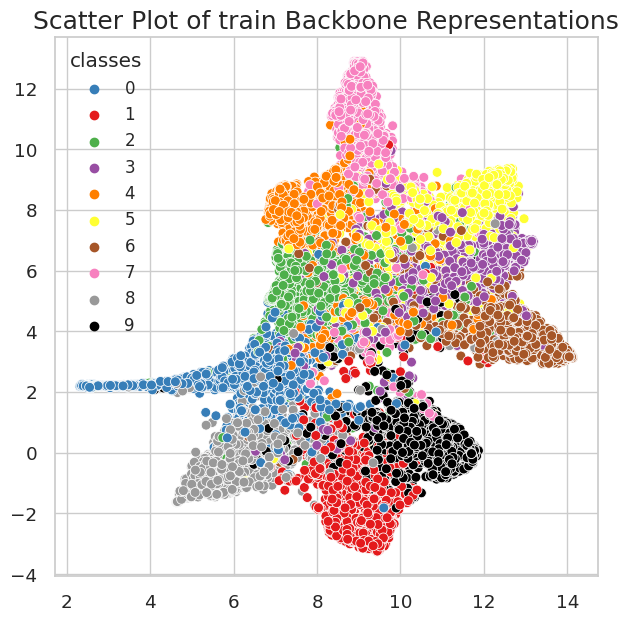

In [138]:
backbone = nn.Sequential(*list(model2.children())[:-1])
import umap.umap_ as umap
import numpy as np

embeddings = []
labels = []
with torch.no_grad():
    for inputs, targets in train_loader_corrupted:
        inputs = inputs.to(device)
        targets = targets.to(device)
        feats = backbone(inputs)
        feats = feats.view(feats.size(0), -1)
        embeddings.append(feats.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Reduce the dimensionality of the embeddings to 2 using UMAP
reducer = umap.UMAP()
embeddings_2d = reducer.fit(embeddings)
train_emb = reducer.transform(embeddings)
import matplotlib.pyplot as plt


import seaborn as sns

sns.set(style='whitegrid', font_scale=1.2)

# Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000']
plt.figure(figsize=(7, 7))
sns.scatterplot(x=train_emb[:, 0], y=train_emb[:, 1], hue=labels, s=50, palette=colors)

# Add axis labels and title
plt.title('Scatter Plot of train Backbone Representations', fontsize=18)

# Add legend
plt.legend(title='classes', loc='best', fontsize=12)

# Add grid lines
plt.grid(True)

        
# Show the plot
plt.show()

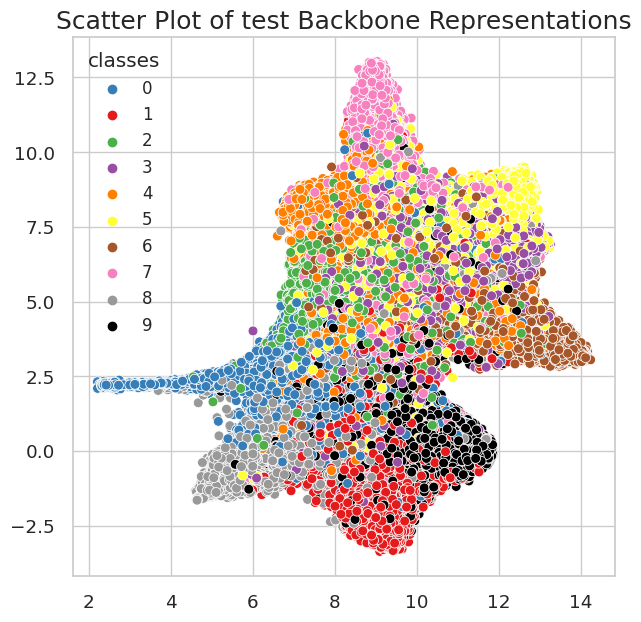

In [139]:
embeddings = []
labels = []
with torch.no_grad():
    for inputs, targets in val_loader_corrupted:
        inputs = inputs.to(device)
        targets = targets.to(device)
        feats = backbone(inputs)
        feats = feats.view(feats.size(0), -1)
        embeddings.append(feats.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Reduce the dimensionality of the embeddings to 2 using UMAP
test_emb = reducer.transform(embeddings)
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.2)

# Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000']
plt.figure(figsize=(7, 7))
sns.scatterplot(x=test_emb[:, 0], y=test_emb[:, 1], hue=labels, s=50, palette=colors)

# Add axis labels and title
plt.title('Scatter Plot of test Backbone Representations', fontsize=18)

# Add legend
plt.legend(title='classes', loc='best', fontsize=12)

# Add grid lines
plt.grid(True)

        
# Show the plot
plt.show()

In [ ]:
# Assuming you have a DataLoader called 'dataloader' that loads your data
embeddings = []
labels = []
with torch.no_grad():
    for inputs, targets in val_loader_perturbate:
        inputs = inputs.to(device)
        targets = targets.to(device)
        feats = backbone(inputs)
        feats = feats.view(feats.size(0), -1)
        embeddings.append(feats.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Reduce the dimensionality of the embeddings to 2 using UMAP
test_emb = reducer.transform(embeddings)
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.2)

# Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000']
plt.figure(figsize=(7, 7))
sns.scatterplot(x=test_emb[:, 0], y=test_emb[:, 1], hue=labels, s=50, palette=colors)

# Add axis labels and title
plt.title('Scatter Plot of test Backbone Representations using corrupted data', fontsize=18)

# Add legend
plt.legend(title='classes', loc='best', fontsize=12)

# Add grid lines
plt.grid(True)

        
# Show the plot
plt.show()

In [141]:
correct_test = 0
total_test = 0
model.eval()
for data in val_loader_perturbate:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    #inputs = fast_gradient_method(model_fn=model, x=inputs, eps=0.1, norm=np.inf)
    outputs = model2(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

# Print test accuracy
print(f"Test Accuracy: {(100*correct_test/total_test):.2f}%")

Test Accuracy: 58.35%


test on corrupted dataset + fgm

In [143]:
correct_test = 0
total_test = 0
model.eval()
for data in val_loader_perturbate:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = fast_gradient_method(model_fn=model2, x=inputs, eps=0.1, norm=np.inf)
    outputs = model2(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

# Print test accuracy
print(f"Test Accuracy: {(100*correct_test/total_test):.2f}%")

Test Accuracy: 35.30%


In [ ]:
#model1 = torchvision.models.resnet18(pretrained=False)
#model1.fc = torch.nn.Linear(in_features=model1.fc.in_features, out_features=10)

#state_dict = torch.load('/content/resnet18.pth')
#model1.load_state_dict(state_dict)
#model1.to(device)

In [123]:
import torch
import torchvision.models as models

# Load the ResNet18 model
model1 = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model1.parameters(), lr=0.01, weight_decay=0.01)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [124]:
import matplotlib.pyplot as plt

# Initialize lists to store data for plotting
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 25
for epoch in range(num_epochs):
    # Training loop
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader_corrupted, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = fast_gradient_method(model_fn=model1, x=inputs, eps=0.1, norm=np.inf)
        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_loader_corrupted)
    epoch_acc = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Epoch {epoch+1},: Training Loss {epoch_loss:.3f}")

    # Validation loop
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader_corrupted:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model1(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        # Save validation data
        val_losses.append(val_loss / len(val_loader_corrupted))
        val_accs.append(100 * correct_val / total_val)

    # Print validation accuracy for each epoch
    print(f"Epoch {epoch+1} - Validation Accuracy: {(100*correct_val/total_val):.2f}%")
    print(f"Epoch {epoch+1} - Validation Loss: {(val_loss/len(val_loader))}")


Epoch 1,: Training Loss 2.379
Epoch 1 - Validation Accuracy: 26.95%
Epoch 1 - Validation Loss: 2.069906018257141
Epoch 2,: Training Loss 2.163
Epoch 2 - Validation Accuracy: 30.99%
Epoch 2 - Validation Loss: 1.90291845925649
Epoch 3,: Training Loss 2.045
Epoch 3 - Validation Accuracy: 33.17%
Epoch 3 - Validation Loss: 1.8195652004877727
Epoch 4,: Training Loss 1.989
Epoch 4 - Validation Accuracy: 34.24%
Epoch 4 - Validation Loss: 1.8157276414235433
Epoch 5,: Training Loss 1.946
Epoch 5 - Validation Accuracy: 34.61%
Epoch 5 - Validation Loss: 1.8256738198598226
Epoch 6,: Training Loss 1.926
Epoch 6 - Validation Accuracy: 38.84%
Epoch 6 - Validation Loss: 1.681125025431315
Epoch 7,: Training Loss 1.884
Epoch 7 - Validation Accuracy: 38.59%
Epoch 7 - Validation Loss: 1.6929385782877604
Epoch 8,: Training Loss 1.860
Epoch 8 - Validation Accuracy: 41.14%
Epoch 8 - Validation Loss: 1.6320182752609254
Epoch 9,: Training Loss 1.830
Epoch 9 - Validation Accuracy: 40.63%
Epoch 9 - Validation Los

<ipython-input-125-013bc8ce6a29>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


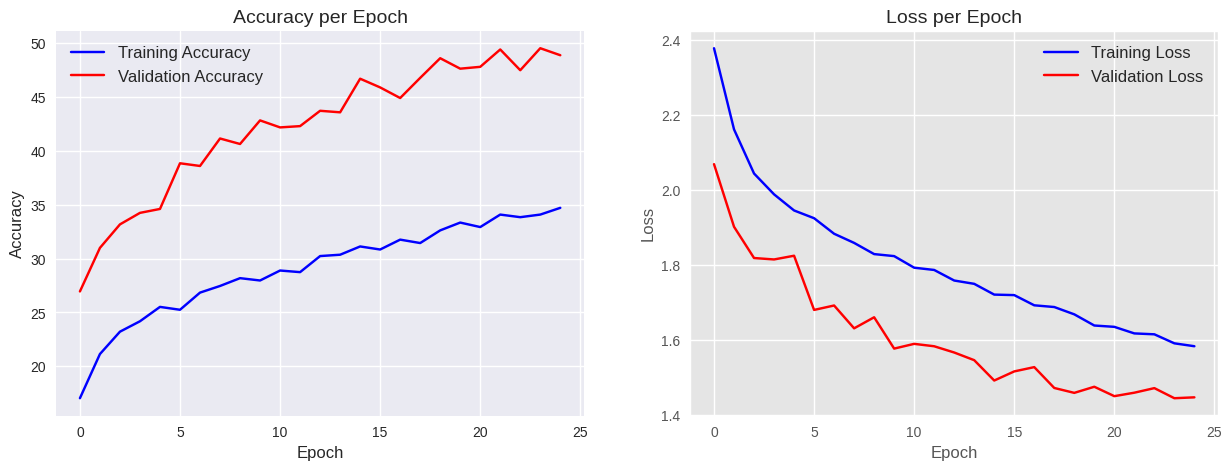

In [125]:
style.use('seaborn')

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Training Accuracy", color = "blue")
plt.plot(val_accs, label="Validation Accuracy", color = "red")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy per Epoch", fontsize=14)
plt.legend(fontsize=12)
plt.style.use("ggplot")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Training Loss", color = "blue")
plt.plot(val_losses, label="Validation Loss", color = "red")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss per Epoch", fontsize=14)
plt.style.use("ggplot")
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

test on corrupted dataset

In [126]:
correct_test = 0
total_test = 0
model1.eval()
for data in val_loader_perturbate:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    #inputs = fast_gradient_method(model_fn=model, x=inputs, eps=0.1, norm=np.inf)
    outputs = model1(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

# Print test accuracy
print(f"Test Accuracy: {(100*correct_test/total_test):.2f}%")

Test Accuracy: 49.24%


test on corrupted dataset + fgm

In [127]:
correct_test = 0
total_test = 0
model1.eval()
for data in val_loader_perturbate:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = fast_gradient_method(model_fn=model1, x=inputs, eps=0.1, norm=np.inf)
    outputs = model1(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

# Print test accuracy
print(f"Test Accuracy: {(100*correct_test/total_test):.2f}%")

Test Accuracy: 28.79%
